#### Date: Dec. 3, 2022
#### Authors: Alison Errico, David Tang

Description
- Creates choropleth maps of Wisconsin by zip code
- These are colored by ADI, site density and cold spots (defined in code below)

To Do:
- Sites by zipcode have a very long tail (i.e. a few with extremely high density). It should be checked if this accurately represents the real world or is an artifact of the data


# Socioeconomic scores : Area deprivation index (ADI)

Area deprivation index (ADI): Is a composite index that ranks neighborhoods by socioeconomic disadvantage in a specific region of interest (state or national level). It was developed by the University of Wisconsin-Madison.

    - The composite index is calculated with different inputs such as income, education, employment, and housing quality.
    - It is originally aggregated at the Census block group level (neighborhood unit), but has a mapping file for zip codes.
    - At the national level, the ADI scores are expressed as percentiles (1-100).
    - At the state level, the ADI scores are expressed as deciles (1-10), where 1 represents the least disadvantaged neighborhoods, while 10 are the most disadvantaged neighborhood. 
 
 
You can find more information about the ADI here: https://www.neighborhoodatlas.medicine.wisc.edu/

### 1. Loading ADI dataset

We downloaded previously the ADI dataset for Wisconsin state only from https://www.neighborhoodatlas.medicine.wisc.edu/ and exported to a csv file. Each column represents:
- ZIP_4: The 9 digit zip code ID 
- FIPS: The block group Census ID
- GISJOIN: Key linkage field to the block group shapefile served by NHGIS
- ADI_NATRANK: National percentile of block group ADI score
- ADI_STATERNK: State-specific decile of block group ADI score

In [1]:
import pandas as pd

SOCIOECONOMIC_FILE = '../external_datasets/socioeconomic_dataset/socioeconomic_scores_zipcode.csv'

df_socioec_scores = pd.read_csv(SOCIOECONOMIC_FILE)
df_socioec_scores.head(5)

ZIP_4          GISJOIN          FIPS ADI_NATRANK ADI_STATERANK TYPE
0  530010064  G55011700110002  5.511701e+11          47             4     
1  530010061  G55011700110002  5.511701e+11          47             4     
2  530010063  G55011700110002  5.511701e+11          47             4     
3  530010049  G55011700112001  5.511701e+11          45             3     
4  530010050  G55011700112001  5.511701e+11          45             3

### 2. Cleaning the dataset

We have some interesting challenges with this dataset and we'd only need 2 columns:
    - ZIP_4: We would need to transform to 5 digit zip code only to align it with UWWisconsin dataset.
    - ADI_STATERANK: It has more than 10 values, such as GQ,PH, GQ-PH. We'd need to clean it. More here: https://www.neighborhoodatlas.medicine.wisc.edu/

An initial solution to clean this dataset: (up to discussion)
    - Group the dataset by 5-digit zip code and assign the average rank within each group.

In [2]:
def clean_adi(df_original):
    
    # Let's create the cleaned dataset
    df_clean = df_original.copy()
    
    # Extract only 5 digits from zipcode
    df_clean['ZIP'] = df_clean['ZIP_4'].astype(str).str[:5]
    
    # Remove zipcodes that don't have a valid decile
    df_clean = df_clean.loc[(df_clean.ADI_STATERANK!='GQ') &
                                         (df_clean.ADI_STATERANK!='PH') &
                                          (df_clean.ADI_STATERANK!='GQ-PH') &
                                        (~df_clean.ADI_STATERANK.isna())
                                         ]
    # Transform state rank to integer
    df_clean['ADI_STATERANK'] = df_clean['ADI_STATERANK'].astype(int)
    
    # IMPORTANT: Assign each zipcode the average rank from their block neighborhoods 
    df_clean = df_clean[['ZIP','ADI_STATERANK']].groupby(['ZIP']).\
                                                                agg({'ADI_STATERANK':'mean'}).reset_index()
    
    
    return df_clean[['ZIP','ADI_STATERANK']]

In [5]:
df_clean = clean_adi(df_socioec_scores)
df_clean.head(5)

ZIP  ADI_STATERANK
0  53001       3.680292
1  53002       4.310638
2  53003       2.000000
3  53004       2.960118
4  53005       1.497231

### 3. Creating a Choropleth to show ADI by zip codes

We will use the Folium library to plot the zipcodes and their corresponding ADI value. For this task we will need a ZIPCODE GeoJSON file for Wisconsin.


In [59]:
# Install folium library
!pip install folium

In [4]:
import folium
import pandas as pd
import json
import requests

In [ ]:
# GeoJSON file definition
wisconsin_geojson = "https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/wi_wisconsin_zip_codes_geo.min.json"


# Creating the map centered at Wisconsin state
m = folium.Map(location=[44.808444, -89.673194], 
               tiles="cartodbpositron", 
               zoom_start=6.8)

# Creating the Choropleth
m.choropleth(geo_data=json.loads(requests.get(wisconsin_geojson).text),
             data=df_clean,
             columns=['ZIP', 'ADI_STATERANK'],
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='YlOrRd', fill_opacity=1, line_opacity=0.2,
             legend_name='Area Deprivation Index : 1(Least disadvantaged)-10(Most disadvantaged))')

# m


In [61]:
m.save(outfile = './choropleth_wisconsin.html' )

### 4. Final thoughts of this dataset

Finally, let's reflect into the next questions before using this dataset for our Datadive event!
    - Is the zipcode the best neighborhood unit to match information from UWWisconsin calls?
    - Can we find another way to aggregate the scores (currently: average)?
    - Is this information enough to draw conclusions for our analysis? Do we need an additional socioeconomic dataset?


## Service Sites per Zip Code ##

In [6]:
sites = pd.read_csv('../uwwi_datasets/uwwi_dataset_sites_encoded.csv')
sites.head()

AgencySystem_Name  Agency_Id  Site_Id  Site_AgencyId  \
0        INTEGRATED COMMUNITY SOLUTIONS          1    414.0            1.0   
1        INTEGRATED COMMUNITY SOLUTIONS          1    418.0            1.0   
2                   INTERIM HEALTH CARE          2    419.0            2.0   
3  zzinactive_INTERNATIONAL TRANSLATORS          3    420.0            3.0   
4                JACKIE NITSCHKE CENTER          4    421.0            4.0   

       Site_CreateStamp        Site_EditStamp  Site_AuditStamp Site_Status  \
0  2017-03-16T15:32:21Z  2022-05-12T17:53:25Z              NaN      active   
1  2017-03-16T15:32:22Z  2021-10-22T00:48:22Z              NaN      active   
2  2017-03-16T15:32:23Z  2022-11-30T19:36:50Z              NaN      active   
3  2017-03-16T15:32:23Z  2021-07-28T04:57:41Z              NaN      active   
4  2017-03-16T15:32:23Z  2022-09-28T15:20:58Z              NaN      active   

  SiteSystem_Active                                    SiteSystem_Name  ...  \
0               Yes                     INTEGRATED COMMUNITY SOLUTIONS  ...   
1                No            ZZZINACTIVE LEAVING HOMELESSNESS BEHIND  ...   
2               Yes                                INTERIM HEALTH CARE  ...   
3                No  zzinactive_VILLA REAL DBA INTERNATIONAL TRANSL...  ...   
4               Yes                             JACKIE NITSCHKE CENTER  ...   

  Start_Thu Start_Fri Start_Sat End_Sun End_Mon End_Tue End_Wed End_Thu  \
0      8:00      8:00       NaN     NaN   16:30   16:30   16:30   16:30   
1       NaN       NaN       NaN     NaN     NaN     NaN     NaN     NaN   
2      8:30      8:30       NaN     NaN   17:00   17:00   17:00   17:00   
3       NaN       NaN       NaN     NaN     NaN     NaN     NaN     NaN   
4      7:00      7:00       NaN     NaN   18:30   18:30   18:30   18:30   

  End_Fri  End_Sat  
0   16:30      NaN  
1     NaN      NaN  
2   17:00      NaN  
3     NaN      NaN  
4   16:30      NaN  

[5 rows x 46 columns]

In [7]:
sites_zip = sites[['Site_Id', 'SiteAddressus_SiteAddressus_zip']]

In [8]:
sites_zip['SiteAddressus_SiteAddressus_zip'].isna().sum()/len(sites_zip)*100

4.790360977505709

### 4.7% of sites list no zip code. Removing these sites for now. ##

In [9]:
sites_zip = sites_zip.dropna()

In [10]:
sites_zip.columns = ['Site_Id', 'Zip']
sites_zip.head()

Site_Id    Zip
0    414.0  54304
1    418.0  54304
2    419.0  54303
3    420.0  54301
4    421.0  54301

In [11]:
sites_zip['Zip-5'] = sites_zip['Zip'].astype(str).str[:5]

In [12]:
sites_zip 

Site_Id    Zip  Zip-5
0        414.0  54304  54304
1        418.0  54304  54304
2        419.0  54303  54303
3        420.0  54301  54301
4        421.0  54301  54301
...        ...    ...    ...
20575  48175.0  53065  53065
20576  48176.0  53226  53226
20578  48178.0  53024  53024
20581  48182.0  53027  53027
20582  48183.0  54893  54893

[19597 rows x 3 columns]

In [13]:
site_count = sites_zip[['Site_Id', 'Zip-5']].groupby('Zip-5').agg('count').reset_index()
site_count

Zip-5  Site_Id
0     03826        1
1     06111        1
2     10001        3
3     10003        1
4     10004        2
...     ...      ...
1236  97272        1
1237  97301        1
1238  97331        2
1239  98106        1
1240  98465        1

[1241 rows x 2 columns]

In [14]:
site_count.columns = ['Zip','Number of Sites']

In [15]:
site_count.describe()

Number of Sites
count      1241.000000
mean         15.791297
std          35.282923
min           1.000000
25%           1.000000
50%           3.000000
75%          12.000000
max         347.000000

In [ ]:
# Creating the map centered at Wisconsin state
m = folium.Map(location=[44.808444, -89.673194], 
               tiles="cartodbpositron", 
               zoom_start=6.8)

# Creating the Choropleth
chor = folium.Choropleth(geo_data=json.loads(requests.get(wisconsin_geojson).text),
             data=site_count,
             columns=['Zip', 'Number of Sites'],
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='YlOrRd', fill_opacity=1, line_opacity=0.2, nan_fill_color="White",
             legend_name='Number of Sites').add_to(m)

folium.GeoJsonTooltip(fields=['ZCTA5CE10'], aliases=['Zip Code']).add_to(chor.geojson)
  
folium.LayerControl().add_to(m)

m

In [ ]:
site_count_indexed = site_count.set_index('Zip')
geo_data=json.loads(requests.get(wisconsin_geojson).text)

In [37]:
site_count_indexed.loc['97272', 'Number of Sites']

1

In [41]:
for s in geo_data['features']:
    try:
        s['properties']['Number of Sites'] = str(site_count_indexed.loc[s['properties']['ZCTA5CE10'], 'Number of Sites'])
    except:
        pass

In [ ]:
# Creating the map centered at Wisconsin state
m = folium.Map(location=[44.808444, -89.673194], 
               tiles="cartodbpositron", 
               zoom_start=6.8)

# Creating the Choropleth
chor = folium.Choropleth(geo_data=geo_data,
             data=site_count,
             columns=['Zip', 'Number of Sites'],
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='YlOrRd', fill_opacity=1, line_opacity=0.2, nan_fill_color="White",
             legend_name='Number of Sites').add_to(m)

folium.GeoJsonTooltip(fields=['ZCTA5CE10', 'Number of Sites'], aliases=['Zip Code', 'Number of Sites']).add_to(chor.geojson)
  
folium.LayerControl().add_to(m)

m

In [43]:
m.save(outfile = './sites_per_zip_with tooltips.html' )

In [44]:
# Creating an arbitrary non-linear color legend

import matplotlib.pyplot as plt

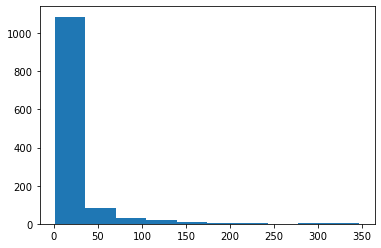

In [45]:
plt.hist(site_count['Number of Sites'])
plt.show()

Zipcode quartiles:
- First quartile have 1 site
- Second quartile have 1-3 sites
- Third quartile have 3-12 sites
- Fourth quartile have 12-347 sites

Creating Site Density Categories 1-4 using fairly arbitrary bins:

In [46]:
site_count['Site Density Category'] = pd.cut(site_count['Number of Sites'], bins=[0, 50, 100, 200, 350], labels = [1, 2, 3, 4])
site_count['Site Density Category'].value_counts()

1    1132
2      64
3      36
4       9
Name: Site Density Category, dtype: int64

In [47]:
site_count_indexed = site_count.set_index('Zip')
for s in geo_data['features']:
    try:
        s['properties']['Site Density Category'] = str(site_count_indexed.loc[s['properties']['ZCTA5CE10'], 'Site Density Category'])
    except:
        pass

In [ ]:
# Creating the map centered at Wisconsin state
cat_map = folium.Map(location=[44.808444, -89.673194], 
               tiles="cartodbpositron", 
               zoom_start=6.8)

# Creating the Choropleth
chor = folium.Choropleth(geo_data=geo_data,
             data=site_count,
             columns=['Zip', 'Site Density Category'],
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='YlOrRd', fill_opacity=1, line_opacity=0.2, nan_fill_color="White",
             legend_name='Site Density Category: 1(Low)-4(High)').add_to(cat_map)

folium.GeoJsonTooltip(fields=['ZCTA5CE10', 'Site Density Category'], aliases=['Zip Code', 'Site Density Category']).add_to(chor.geojson)
  
folium.LayerControl().add_to(cat_map)
cat_map

In [49]:
cat_map.save(outfile = './site_density_category_with tooltips.html' )

In [51]:
zip_pop = pd.read_csv('./population_zip.csv')
zip_pop.columns = ['Zip', 'Population']

In [52]:
zip_pop['Zip'] = zip_pop['Zip'].astype(str)

In [53]:
site_pop = site_count.merge(zip_pop, on='Zip')

In [54]:
site_pop['Sites Per 1000 People'] = (site_pop['Number of Sites'] / (site_pop['Population']/1000))
site_pop['Sites Per Capita'] = (site_pop['Number of Sites'] / site_pop['Population'])
site_pop.head()

Zip  Number of Sites Site Density Category  Population  \
0  53001                2                     1        1806   
1  53002                2                     1        2181   
2  53003                1                     1         138   
3  53004                4                     1        3428   
4  53005               63                     2       20514   

   Sites Per 1000 People  Sites Per Capita  
0               1.107420          0.001107  
1               0.917011          0.000917  
2               7.246377          0.007246  
3               1.166861          0.001167  
4               3.071073          0.003071

In [55]:
site_pop.describe()

Number of Sites    Population  Sites Per 1000 People  Sites Per Capita
count       668.000000    668.000000             668.000000        668.000000
mean         26.766467   8527.544910               3.908813          0.003909
std          44.604367  10814.180397               8.152657          0.008153
min           1.000000     10.000000               0.254323          0.000254
25%           3.000000   1702.750000               1.413576          0.001414
50%           9.000000   3492.500000               2.433166          0.002433
75%          29.250000  10261.500000               3.995269          0.003995
max         347.000000  61028.000000             150.000000          0.150000

In [133]:
site_pop.to_csv('./site_pop.csv', index=False)

In [56]:
# Log-density value to shrink large range

import numpy as np

site_pop['Log Sites Per 1000 People'] = np.log10(site_pop['Sites Per 1000 People'])
site_pop.describe()

Number of Sites    Population  Sites Per 1000 People  Sites Per Capita  \
count       668.000000    668.000000             668.000000        668.000000   
mean         26.766467   8527.544910               3.908813          0.003909   
std          44.604367  10814.180397               8.152657          0.008153   
min           1.000000     10.000000               0.254323          0.000254   
25%           3.000000   1702.750000               1.413576          0.001414   
50%           9.000000   3492.500000               2.433166          0.002433   
75%          29.250000  10261.500000               3.995269          0.003995   
max         347.000000  61028.000000             150.000000          0.150000   

       Log Sites Per 1000 People  
count                 668.000000  
mean                    0.393871  
std                     0.363870  
min                    -0.594614  
25%                     0.150318  
50%                     0.386172  
75%                     0.601545  
max                     2.176091

In [57]:
# Creating the map centered at Wisconsin state
percapita_map = folium.Map(location=[44.808444, -89.673194], 
               tiles="cartodbpositron", 
               zoom_start=6.8)

# Creating the Choropleth
folium.Choropleth(geo_data=geo_data,
             data=site_pop,
             columns=['Zip', 'Log Sites Per 1000 People'],
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='YlOrRd', fill_opacity=1, line_opacity=0.2, nan_fill_color="White",
             legend_name='Sites Per 1000 people (log scale)').add_to(percapita_map)

# percapita_map

In [58]:
percapita_map.save(outfile = './per_capita_map.html' )

## Identifying cold zones ##

In [140]:
site_count
df_clean

ZIP  ADI_STATERANK
0    53001       3.680292
1    53002       4.310638
2    53003       2.000000
3    53004       2.960118
4    53005       1.497231
..     ...            ...
871  54982       8.295963
872  54983       7.214618
873  54984       6.809798
874  54985       8.000000
875  54986       4.281970

[876 rows x 2 columns]

In [59]:
df_clean.columns = ['Zip','ADI_STATERANK']
sites_with_adi = site_count.merge(df_clean, on='Zip', how='inner')
sites_with_adi

Zip  Number of Sites Site Density Category  ADI_STATERANK
0    53001                2                     1       3.680292
1    53002                2                     1       4.310638
2    53003                1                     1       2.000000
3    53004                4                     1       2.960118
4    53005               63                     2       1.497231
..     ...              ...                   ...            ...
713  54982               51                     2       8.295963
714  54983               11                     1       7.214618
715  54984                8                     1       6.809798
716  54985                2                     1       8.000000
717  54986                6                     1       4.281970

[718 rows x 4 columns]

Creating a map and list of "cold" neighborhoods with low number of services and high Area Deprivation Index:

In [60]:
cold_zips = sites_with_adi[(sites_with_adi['Site Density Category'] == 1) & (sites_with_adi['ADI_STATERANK'] >= 8)]

In [61]:
cold_zips

Zip  Number of Sites Site Density Category  ADI_STATERANK
154  53295                9                     1      10.000000
158  53404               41                     1       8.166667
161  53408                2                     1       8.000000
172  53512                5                     1       9.000000
200  53547                9                     1       8.000000
..     ...              ...                   ...            ...
684  54936                2                     1      10.000000
698  54957                2                     1       9.000000
704  54966                7                     1       8.115019
711  54978                1                     1       9.000000
716  54985                2                     1       8.000000

[72 rows x 4 columns]

Map of Cold Zones

In [ ]:
# Creating the map centered at Wisconsin state
cold_map = folium.Map(location=[44.808444, -89.673194], 
               tiles="cartodbpositron", 
               zoom_start=6.8)

# Creating the Choropleth
folium.Choropleth(geo_data=json.loads(requests.get(wisconsin_geojson).text),
             data=cold_zips,
             columns=['Zip', 'ADI_STATERANK'],
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='OrRd', fill_opacity=1, line_opacity=0.2, nan_fill_color="White",
             legend_name='Area Deprivation Index : 1(Least disadvantaged)-10(Most disadvantaged)').add_to(cold_map)

# cold_map

Merging with city list to get a list of "cold" cities:

In [62]:
sites_cities = sites[['SiteAddressus_SiteAddressus_zip', 'SiteAddressus_SiteAddressus_city']]

In [63]:
sites_cities.columns = ['Zip', 'City']
sites_cities = sites_cities.drop_duplicates(subset='Zip')
sites_cities['City'] = sites_cities['City'].str.title()
sites_cities

Zip           City
0      54304      Green Bay
2      54303      Green Bay
3      54301      Green Bay
5      54311      Green Bay
7      54313      Green Bay
...      ...            ...
20195  54854          Maple
20198  54874    South Range
20200  54890        Wascott
20244  94118  San Francisco
20335  80205         Denver

[1247 rows x 2 columns]

In [66]:
sites_cities_indexed = sites_cities.set_index('Zip')

In [67]:
for s in geo_data['features']:
    try:
        s['properties']['City'] = str(sites_cities_indexed.loc[s['properties']['ZCTA5CE10'], 'City'])
    except:
        pass

In [ ]:
# Creating the map centered at Wisconsin state
cold_map = folium.Map(location=[44.808444, -89.673194], 
               tiles="cartodbpositron", 
               zoom_start=6.8)

# Creating the Choropleth
chor = folium.Choropleth(geo_data=geo_data,
             data=cold_zips,
             columns=['Zip', 'ADI_STATERANK'],
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='OrRd', fill_opacity=1, line_opacity=0.2, nan_fill_color="White",
             legend_name='Area Deprivation Index : 1(Least disadvantaged)-10(Most disadvantaged)').add_to(cold_map)

folium.GeoJsonTooltip(fields=['ZCTA5CE10', 'City'], aliases=['Zip Code', 'City']).add_to(chor.geojson)
  
folium.LayerControl().add_to(cold_map)
cold_map

In [70]:
cold_map.save(outfile = './cold_zones_with_tooltips.html' )

In [64]:
cold_cities = cold_zips.merge(sites_cities, on='Zip')
cold_cities

Zip  Number of Sites Site Density Category  ADI_STATERANK         City
0   53295                9                     1      10.000000    Milwaukee
1   53404               41                     1       8.166667       Racine
2   53408                2                     1       8.000000       Racine
3   53512                5                     1       9.000000       Beloit
4   53547                9                     1       8.000000   Janesville
..    ...              ...                   ...            ...          ...
67  54936                2                     1      10.000000  Fond Du Lac
68  54957                2                     1       9.000000       Neenah
69  54966                7                     1       8.115019   Plainfield
70  54978                1                     1       9.000000      Tilleda
71  54985                2                     1       8.000000    Winnebago

[72 rows x 5 columns]

In [152]:
cold_cities['City'].unique()

array(['Milwaukee', 'Racine', 'Beloit', 'Janesville', 'Muscoda', 'Benton',
       'Cassville', 'Patch Grove', 'Adams', 'Friendship', 'Grand Marsh',
       'Kingston', 'Amberg', 'Armstrong Creek', 'Athelstane', 'Crivitz',
       'Florence', 'Gillett', 'Goodman', 'Keshena', 'Neopit', 'Niagara',
       'Pembine', 'Suring', 'Manitowoc', 'Two Rivers', 'Green Bay',
       'Wausau', 'Antigo', 'Bowler', 'Dorchester', 'Elderon', 'Mattoon',
       'Port Edwards', 'Rib Lake', 'Tigerton', 'Westboro', 'White Lake',
       'Wittenberg', 'Butternut', 'Catawba', 'Glen Flora', 'Hawkins',
       'Heafford Junction', 'Hurley', 'Alvin', 'Mellen', 'Montreal',
       'Prentice', 'Wabeno', 'La Crosse', 'Arkdale', 'La Farge',
       'Readstown', 'Seneca', 'Viola', 'Gilmanton', 'Whitehall', 'Bruce',
       'Centuria', 'Odanah', 'Turtle Lake', 'Winter', 'Oshkosh',
       'Appleton', 'Butte Des Morts', 'Fond Du Lac', 'Neenah',
       'Plainfield', 'Tilleda', 'Winnebago'], dtype=object)

In [153]:
cold_map.save(outfile = './cold_zones.html' )

In [154]:
cold_cities = cold_cities.drop(columns = ['Site Density Category'])
cold_cities

Zip  Number of Sites  ADI_STATERANK         City
0   53295                9      10.000000    Milwaukee
1   53404               41       8.166667       Racine
2   53408                2       8.000000       Racine
3   53512                5       9.000000       Beloit
4   53547                9       8.000000   Janesville
..    ...              ...            ...          ...
67  54936                2      10.000000  Fond Du Lac
68  54957                2       9.000000       Neenah
69  54966                7       8.115019   Plainfield
70  54978                1       9.000000      Tilleda
71  54985                2       8.000000    Winnebago

[72 rows x 4 columns]

In [155]:
cold_cities.to_csv('./cold_cities.csv', index=False)